# Feature Map Visualization
ref: https://machinelearningmastery.com/how-to-visualize-filters-and-feature-maps-in-convolutional-neural-networks/ <br>
ref: https://www.kdnuggets.com/2018/04/building-convolutional-neural-network-numpy-scratch.html

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import os
from os.path import join
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import callbacks
from time import time
from datetime import datetime
import shutil 
import argparse
from functools import partial
import pickle
from IPython.display import Audio

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Reshape, GRU, InputLayer, AlphaDropout, Activation, BatchNormalization, Dropout, Flatten, Dense, Bidirectional, LSTM, Conv1D, SpatialDropout1D, Concatenate, Multiply, Add

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

In [3]:
np_load_old = partial(np.load)
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

In [4]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

def R2(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred), axis = 0) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true, axis = 0)), axis = 0) 
    return K.mean(1 - (SS_res/SS_tot), axis=0)

## Load Data 

In [5]:
#Function for preprocessing data
def delete_params(params):
    DEL_PARAMS_LIST = [2,8,15,16,21,22,23]
    return np.delete(params,DEL_PARAMS_LIST , axis=1)

In [6]:
dataset = np.load(join('../../data/d_eval','prep_data_13_2','eval_dataset.npz'))
features =dataset['features']
labels= dataset['labels']
labels = delete_params(labels)
print('Eval features and labels %s %s'%(str(features.shape),str(labels.shape)))

Eval features and labels (264, 24, 39) (264, 17)


## Load Model 

In [7]:
model = tf.keras.models.load_model('../../experiment_2/model/117_senet.h5', custom_objects={'rmse': rmse, 'R2':R2})
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24, 39)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 24, 128)      35072       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 24, 128)      512         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 24, 128)      0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [8]:
features_list = [layer.output for layer in model.layers[:-8]]
submodel = keras.Model(inputs=model.input, outputs=features_list)
submodel.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 24, 39)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 24, 128)      35072       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 24, 128)      512         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 24, 128)      0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [9]:
extracted_features = submodel(features)

In [10]:
# the feature from each layer
len(extracted_features)

15

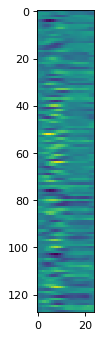

In [11]:
plt.figure(num=None, figsize=(3, 5), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(np.swapaxes(extracted_features[12].numpy()[3], 0 ,1))

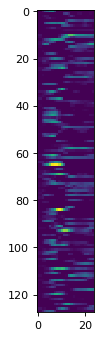

In [12]:
plt.figure(num=None, figsize=(3, 5), dpi=80, facecolor='w', edgecolor='k')
filters = extracted_features[8].numpy()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
plt.imshow(np.swapaxes(filters[3], 0 ,1))

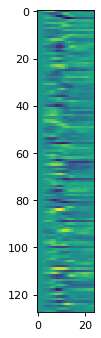

In [13]:
plt.figure(num=None, figsize=(3, 5), dpi=80, facecolor='w', edgecolor='k')
filters = extracted_features[1].numpy()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
plt.imshow(np.swapaxes(filters[3], 0 ,1))

## Visualized Convolutional Weight 

In [14]:
for idx, layer in enumerate(submodel.layers):
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape, idx)

conv1d (7, 39, 128) 1
conv1d_1 (3, 128, 128) 9
conv1d_2 (5, 128, 128) 12


In [15]:
filters, biases = submodel.layers[1].get_weights()

In [16]:
def plot_mfcc(mfcc):
    fig, ax = plt.subplots(figsize=(10,5))
    cax = ax.imshow(np.swapaxes(mfcc, 0 ,1), interpolation='nearest', cmap=cm.coolwarm, origin='lower')
    ax.set_title('MFCC')
    plt.show()

In [17]:
feat = np.pad(features[10], [(3, ), (0, )], mode='constant')
f1 = filters[:,:,0]
filter_size = f1.shape[0]
result = np.zeros((24,39))
for r in np.uint16(np.arange(filter_size/2,feat.shape[0]-filter_size/2-2)):
    curr_region = feat[r:r+filter_size, :] 
    curr_result = curr_region * f1
    conv_sum = np.sum(curr_result, axis=0)
    result[r] = conv_sum
# result = result[3:-3]

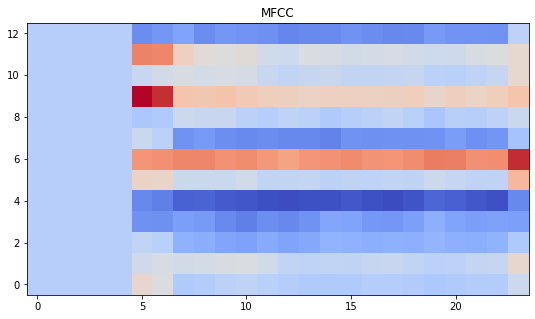

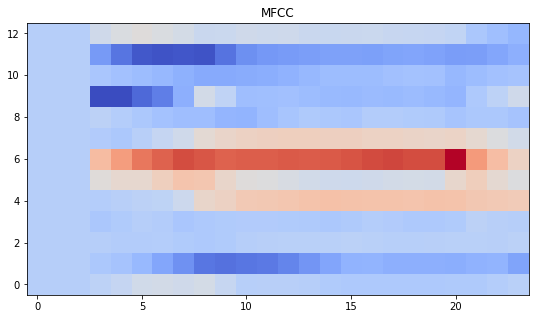

In [18]:
plot_mfcc(features[10][:,:13])
plot_mfcc(result[:,:13])

In [22]:
import librosa
sig = librosa.feature.inverse.mfcc_to_audio(features[10][:,:13], n_mels=13)

In [25]:
Audio(sig, rate=8000)

## Feature Mapping 

In [90]:
fm_model = keras.Model(inputs=model.input, outputs=model.layers[1].output)
feature_maps = fm_model.predict(features)

In [92]:
feature_maps.shape

(264, 24, 128)

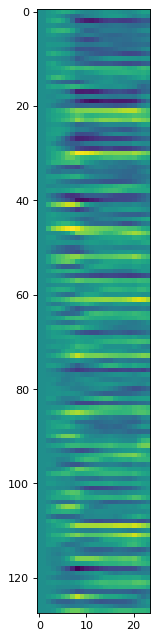

In [94]:
plt.figure(num=None, figsize=(3, 10), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(np.swapaxes(feature_maps[0], 0 ,1))